# How to choose a successful movies genre?

I started my job from importing nessary libraries.

In [3]:
#import libraries for work
import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#connect to the created Database
conn = sqlite3.connect("movies_database.sqlite")
cur = conn.cursor()

In [5]:
#check list of tables
for row in cur.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('tmdb_movies',)
('imdb_title_crew',)
('tn_movie_budgets',)
('imdb_title_ratings',)
('imdb_name_basics',)
('imdb_title_principals',)
('imdb_title_akas',)
('bom_movie_gross',)
('imdb_title_basics',)
('rt_reviews',)
('rt_movie_info',)


------------------------------
# Popularity vs Genre

I want to find the dependence of the popularity of films on their genre and budget. To do this, we work with several tables:

In [96]:
# for closer look on genres union two tables
# order by popularity
cur.execute('''SELECT *
               FROM tmdb_movies tmdb
               JOIN tn_movie_budgets tn
               ON tn.movie = tmdb.original_title
               JOIN imdb_title_basics imdb
               ON imdb.original_title = tn.movie
               ORDER BY popularity DESC
               LIMIT 200
            ''')
movies = pd.DataFrame(cur.fetchall())
movies.columns = [i[0] for i in cur.description]
movies.head(10)

,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,...,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,...,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"
1,11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081,...,John Wick,"$30,000,000","$43,037,835","$76,235,001",tt2911666,John Wick,John Wick,2014,101.0,"Action,Crime,Thriller"
2,11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392,...,The Hobbit: The Battle of the Five Armies,"$250,000,000","$255,119,788","$945,577,621",tt2310332,The Hobbit: The Battle of the Five Armies,The Hobbit: The Battle of the Five Armies,2014,144.0,"Adventure,Fantasy"
3,5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,...,The Avengers,"$225,000,000","$623,279,547","$1,517,935,897",tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi"
4,5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,...,The Avengers,"$60,000,000","$23,385,416","$48,585,416",tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi"
5,11021,"[28, 878, 12]",118340,en,Guardians of the Galaxy,49.606,2014-08-01,Guardians of the Galaxy,7.9,17958,...,Guardians of the Galaxy,"$170,000,000","$333,172,112","$770,867,516",tt2015381,Guardians of the Galaxy,Guardians of the Galaxy,2014,121.0,"Action,Adventure,Comedy"
6,20617,"[878, 28, 53]",335984,en,Blade Runner 2049,48.571,2017-10-06,Blade Runner 2049,7.4,6679,...,Blade Runner 2049,"$185,000,000","$92,054,159","$259,357,408",tt1856101,Blade Runner 2049,Blade Runner 2049,2017,164.0,"Drama,Mystery,Sci-Fi"
7,23813,"[878, 28, 53]",335984,en,Blade Runner 2049,48.571,2017-10-06,Blade Runner 2049,7.4,6679,...,Blade Runner 2049,"$185,000,000","$92,054,159","$259,357,408",tt1856101,Blade Runner 2049,Blade Runner 2049,2017,164.0,"Drama,Mystery,Sci-Fi"
8,23814,[12],338952,en,Fantastic Beasts: The Crimes of Grindelwald,48.508,2018-11-16,Fantastic Beasts: The Crimes of Grindelwald,6.9,4870,...,Fantastic Beasts: The Crimes of Grindelwald,"$200,000,000","$159,555,901","$652,220,086",tt4123430,Fantastic Beasts: The Crimes of Grindelwald,Fantastic Beasts: The Crimes of Grindelwald,2018,134.0,"Adventure,Family,Fantasy"
9,20618,"[28, 12, 878, 18]",315635,en,Spider-Man: Homecoming,46.775,2017-07-07,Spider-Man: Homecoming,7.4,11585,...,Spider-Man: Homecoming,"$175,000,000","$334,201,140","$880,166,350",tt2250912,Spider-Man: Homecoming,Spider-Man: Homecoming,2017,133.0,"Action,Adventure,Sci-Fi"


## Let's select genres from the column with a list of genres

In [97]:
# work with column genre_ids to find a all genres
movies.genre_ids = movies.genre_ids.str.replace('[','')
movies.genre_ids = movies.genre_ids.str.replace(']','')
movies.genre_ids = movies.genre_ids.str.replace(', ',',')
movies.genre_ids = movies['genre_ids'].astype(str)
movies.head(1)

,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,...,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,23811,"12,28,14",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,...,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"


In [98]:
# split all genre_ids for work
movies['genre_ids'] = movies['genre_ids'].map(lambda x: x.split(",") if x else x)

In [118]:
# count genres id
all_genres =[]
none_counter = 0
for genre in movies['genre_ids']:
    if genre == None:
        none_counter += 1
    else:
        all_genres += genre
#all_genres        

In [111]:
# create set of unique genres
unique_genres = set(all_genres)
unique_genres

{'10402',
 '10749',
 '10751',
 '10752',
 '12',
 '14',
 '16',
 '18',
 '27',
 '28',
 '35',
 '36',
 '53',
 '80',
 '878',
 '9648'}

In [114]:
# How many movies we have in each genre?
genre_count = {}
for g in unique_genres:
    genre_count[g] = all_genres.count(g)

In [115]:
genre_count

{'27': 17,
 '10751': 52,
 '10402': 2,
 '14': 70,
 '80': 17,
 '36': 6,
 '18': 71,
 '9648': 10,
 '28': 98,
 '10749': 27,
 '12': 96,
 '53': 51,
 '16': 29,
 '10752': 9,
 '878': 60,
 '35': 38}

## What I can do with genres id?

I found that table **tmdb_movies** has only genre ids without information about it, but on the site https://developers.themoviedb.org/3/genres we can find this information using API. API request gives us JSON files with codes and names of genges and I create a dictionary.

In [16]:
#create a new dictionary for data
# worls log, should found a better solution
genres = {'28': 'Action',
'12': 'Adventure',
'16': 'Animation',
'35': 'Comedy',
'80': 'Crime',
'99': 'Documentary',
'18': 'Drama',
'10751': 'Family',
'14': 'Fantasy',
'36': 'History',
'27': 'Horror',
'10402': 'Music',
'9648': 'Mystery',
'10749': 'Romance',
'878': 'Science Fiction',
'10770': 'TV Movie',
'53': 'Thriller',
'10752': 'War',
'37': 'Western'}

In [116]:
# update genre_count by names from genres
result_table ={}
for g in genre_count.keys():
    result_table[genres[g]]=genre_count[g] 
result_table  

{'Horror': 17,
 'Family': 52,
 'Music': 2,
 'Fantasy': 70,
 'Crime': 17,
 'History': 6,
 'Drama': 71,
 'Mystery': 10,
 'Action': 98,
 'Romance': 27,
 'Adventure': 96,
 'Thriller': 51,
 'Animation': 29,
 'War': 9,
 'Science Fiction': 60,
 'Comedy': 38}

Text(0.5, 1.0, 'Top 200 Most Popular Movies')

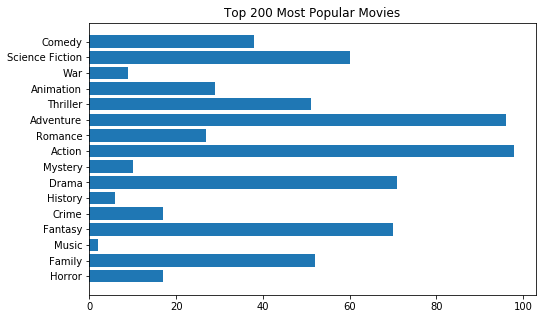

In [117]:
# add new labels for plot
values = []
labels = []

for genre, count in result_table.items():
    labels.append(genre)
    values.append(count)

plt.figure(figsize=(8, 5))
plt.barh(labels, values)
plt.title("Top 200 Most Popular Movies")

**The most popular genres are Action, Adventure, and Drama followed closely by Sci-Fi and Fantasy. Comedy and Family movies try to catch up**

---------

# Worldwide gross vs Genre

In [6]:
# for closer look on genres union two tables
# order by worldwide_gross - most expensive goes first
cur.execute('''SELECT *
               FROM tmdb_movies tmdb
               JOIN tn_movie_budgets tn
               ON tn.movie = tmdb.original_title
               JOIN imdb_title_basics imdb
               ON imdb.original_title = tn.movie
               ORDER BY worldwide_gross DESC
               LIMIT 200
            ''')
movies1 = pd.DataFrame(cur.fetchall())
movies1.columns = [i[0] for i in cur.description]
movies1.tail(3)

,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,...,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres
197,11085,"[28, 878, 18]",110415,ko,Snowpiercer,14.735,2014-06-27,Snowpiercer,6.8,4748,...,Snowpiercer,"$40,000,000","$4,563,029","$88,069,880",tt1706620,Snowpiercer,Snowpiercer,2013,126.0,"Action,Drama,Sci-Fi"
198,5202,"[16, 35, 12, 10751]",57800,en,Ice Age: Continental Drift,17.537,2012-07-13,Ice Age: Continental Drift,6.3,4598,...,Ice Age: Continental Drift,"$95,000,000","$161,321,843","$879,765,137",tt1667889,Ice Age: Continental Drift,Ice Age: Continental Drift,2012,88.0,"Adventure,Animation,Comedy"
199,14175,"[28, 12, 80]",206647,en,Spectre,30.318,2015-11-06,Spectre,6.4,6719,...,Spectre,"$300,000,000","$200,074,175","$879,620,923",tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller"


In [7]:
# work with column genre_ids to find a all genres
movies1.genre_ids = movies1.genre_ids.str.replace('[','')
movies1.genre_ids = movies1.genre_ids.str.replace(']','')
movies1.genre_ids = movies1.genre_ids.str.replace(', ',',')
movies1.genre_ids = movies1['genre_ids'].astype(str)
movies1.head(1)

,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,...,movie,production_budget,domestic_gross,worldwide_gross,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,2498,"27,53",49018,en,Insidious,16.197,2011-04-01,Insidious,6.9,3582,...,Insidious,"$1,500,000","$54,009,150","$99,870,886",tt1591095,Insidious,Insidious,2010,103.0,"Horror,Mystery,Thriller"


In [8]:
# split all genre_ids for work
movies1['genre_ids'] = movies1['genre_ids'].map(lambda x: x.split(",") if x else x)

In [9]:
# count genres id
all_genres1 =[]
none_counter = 0
for genre in movies1['genre_ids']:
    if genre == None:
        none_counter += 1
    else:
        all_genres1 += genre
#all_genres1  

In [10]:
# create set of unique genres
unique_genres = set(all_genres1)
unique_genres

{'10402',
 '10749',
 '10751',
 '10752',
 '12',
 '14',
 '16',
 '18',
 '27',
 '28',
 '35',
 '36',
 '37',
 '53',
 '80',
 '878',
 '9648',
 '99'}

In [11]:
# How many movies we have in each genre?
genre_count1 = {}
for g in unique_genres:
    genre_count1[g] = all_genres1.count(g)
genre_count1

{'9648': 14,
 '53': 46,
 '18': 82,
 '35': 41,
 '28': 45,
 '27': 44,
 '16': 11,
 '14': 14,
 '10402': 3,
 '80': 8,
 '10752': 4,
 '12': 38,
 '10749': 19,
 '37': 1,
 '36': 11,
 '99': 13,
 '10751': 21,
 '878': 8}

In [17]:
# update genre_count by names from genres
result_table1 ={}
for g in genre_count1.keys():
    result_table1[genres[g]]=genre_count1[g] 
result_table1

{'Mystery': 14,
 'Thriller': 46,
 'Drama': 82,
 'Comedy': 41,
 'Action': 45,
 'Horror': 44,
 'Animation': 11,
 'Fantasy': 14,
 'Music': 3,
 'Crime': 8,
 'War': 4,
 'Adventure': 38,
 'Romance': 19,
 'Western': 1,
 'History': 11,
 'Documentary': 13,
 'Family': 21,
 'Science Fiction': 8}

Text(0.5, 1.0, 'Top 200 Worldwide Gross Movies')

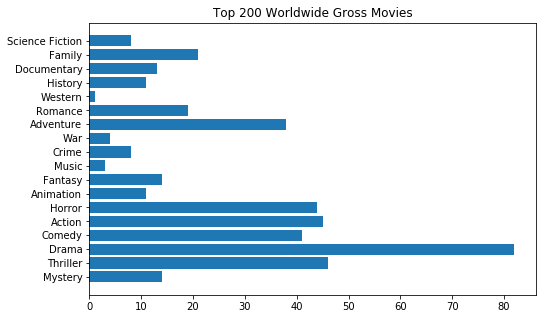

In [18]:
# add new labels for plot
values = []
labels = []

for genre, count in result_table1.items():
    labels.append(genre)
    values.append(count)

plt.figure(figsize=(8, 5))
plt.barh(labels, values)
plt.title("Top 200 Worldwide Gross Movies")

Here Drama seem to be the most popular then Thriller and Action close behind. Horror tries to catch up. However, unlike the most profitable movies, Comedy and Adventure also rank fairly high.

# Conclusion

If you want to create a very popular movie, his genre should be *Action, Adventure, Drama, Fantasy of Science Fiction.*

When you want to earn more then choose *Drama*. People love to be involde into heros lives and share their experiences.